In [7]:
!pip3 uninstall evo -y
!python3 -m pip install -e /home/joshuabird/Documents/multi-agent-evo

Found existing installation: evo 1.26.1
Uninstalling evo-1.26.1:
  Successfully uninstalled evo-1.26.1
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/joshuabird/Documents/multi-agent-evo
  Preparing metadata (setup.py) ... done
  Running setup.py develop for evo


In [8]:
!pip3 install palettable

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
from palettable.cartocolors.qualitative import Prism_10 as colorscheme

plt.style.use('default')
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.size": 11,
        "font.family": "lmodern",
        "legend.fontsize": "x-small",
        "figure.figsize": (15, 5),
        "axes.labelsize": "x-small",
        "axes.titlesize": "x-small",
        "xtick.labelsize": "xx-small",
        "ytick.labelsize": "xx-small",
    }
)

# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

agent_ids = [1,2,3]

In [16]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import math
import numpy as np
from scipy.spatial.transform import Rotation
from pathlib import Path
import os
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types
import copy

# Add custom types
interfaces_dir = "../interfaces/msg/"
for file in os.listdir(interfaces_dir):
    msg_text = Path(interfaces_dir + file).read_text()
    register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))

bag_name = "/home/joshuabird/Desktop/apr11_mh_trajectory_b"

traj_ests = {}
traj_refs = {}
with Rosbag2Reader(bag_name) as reader:
    # Read the trajectory and ground truth for each agent
    for agent_id in agent_ids:
        traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose", transform_to_root_tf_frame_id="/world", use_final_tf_state=True)
        traj_ref = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/ground_truth_pose")

        traj_est.timestamps += 0.17

        traj_ests[agent_id] = traj_est
        traj_refs[agent_id] = traj_ref

/tmp/ipykernel_227202/2508048495.py:16: DeprecationWarning: Global type registration has been replaced with explicit typestores.

Perform all type registration and subsequent serialization and
deserialization on typestore instances:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.register(types)
  register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.


In [17]:
from evo.core.trajectory import PosePath3DElement

filter_func: PosePath3DElement = lambda element: element["coord_frame"] == "robot1/origin"

# Filter to only the time range where trajectories are merged
for agent_id in agent_ids:
    traj_ests[agent_id].filter(filter_func)

# Trim them down to the shortest time range
# max_start_time = max([min(traj_ests[agent_id].timestamps) for agent_id in agent_ids] + [min(traj_refs[agent_id].timestamps) for agent_id in agent_ids])
# min_end_time = min([max(traj_ests[agent_id].timestamps) for agent_id in agent_ids] + [max(traj_refs[agent_id].timestamps) for agent_id in agent_ids])

# for agent_id in agent_ids:
#     traj_ests[agent_id].reduce_to_time_range(max_start_time, min_end_time)
#     traj_refs[agent_id].reduce_to_time_range(max_start_time, min_end_time)


# traj_ests[1].reduce_to_time_range(0, np.max(traj_ests[1].timestamps)-10)
# traj_refs[1].reduce_to_time_range(0, np.max(traj_refs[1].timestamps)-10)

In [18]:
for agent_id in agent_ids:
    print(traj_ests[agent_id])
    print(traj_refs[agent_id])

3662 poses, 17.239m path length, 183.400s duration
3071 poses, 80.536m path length, 186.411s duration
2996 poses, 15.764m path length, 150.800s duration
2466 poses, 73.214m path length, 151.911s duration
2573 poses, 27.432m path length, 130.850s duration
1875 poses, 127.073m path length, 133.404s duration


In [19]:
from evo.core import sync
from evo.core.trajectory import align_multiple

max_diff = 0.05

for agent_id in agent_ids:
    traj_refs[agent_id], traj_ests[agent_id] = sync.associate_trajectories(traj_refs[agent_id], traj_ests[agent_id], max_diff)
    
align_multiple(list(traj_ests.values()), list(traj_refs.values()), correct_scale=True)

[array([[ 0.33413352, -0.89730485, -0.288442  ],
        [ 0.94142358,  0.30293481,  0.14816255],
        [-0.04556785, -0.32105218,  0.94596462]]),
 array([ 4.76282155, -1.79915502,  1.07344302]),
 4.769436276322695]

In [20]:
for agent_id in agent_ids:
    print(traj_refs[agent_id])
    print(traj_ests[agent_id])
    print()

3020 poses, 80.415m path length, 183.409s duration
3020 poses, 81.726m path length, 183.400s duration

2436 poses, 72.918m path length, 150.159s duration
2436 poses, 74.620m path length, 150.100s duration

1833 poses, 125.884m path length, 130.355s duration
1833 poses, 126.624m path length, 130.350s duration



In [21]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure(figsize=(6.7/2, 2.2))
    ax = plot.prepare_axis(fig, plot_mode)
    
    overall_min = np.inf
    overall_max = -np.inf
    
    results = {}

    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results[agent_id] = result

        if result.stats["min"] < overall_min:
            overall_min = result.stats["min"]
        if result.stats["max"] > overall_max:
            overall_max = result.stats["max"]

    for agent_id in agent_ids:
        if show_plot:
            result = results[agent_id]

            plot.traj(ax, plot_mode, traj_refs[agent_id], style=":", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=overall_min, max_map=overall_max, color_bar_label="ATE [m]", show_color_bar=agent_id == agent_ids[-1])
            
        # plt.legend([f"Ground Truth", f"Estimate"], loc="upper right")
    
    plt.tight_layout()
    ax.set_aspect("equal")

    # save as file
    if show_plot:
        fig.savefig(f'figures_output/{bag_name.split("/")[-1]}_trajectory.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)
        
        

    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

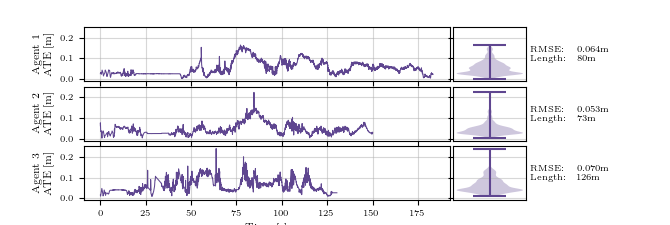

In [22]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0

def callback_ape(pose_relation, align, correct_scale, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig, axs = plt.subplots(len(agent_ids), 3, sharex=False, sharey=True, gridspec_kw={'width_ratios': [5, 1, 1]}, figsize=(6.7, 0.75*len(agent_ids)))
    plt.subplots_adjust(hspace=0.1, wspace=0.02)

    # share x axis along first columns
    for i in range(len(agent_ids)-1):
        axs[i][0].sharex(axs[i+1][0])
    
    overall_min = np.inf
    overall_max = -np.inf
    
    results = {}

    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results[agent_id] = result

        if result.stats["min"] < overall_min:
            overall_min = result.stats["min"]
        if result.stats["max"] > overall_max:
            overall_max = result.stats["max"]

    for agent_id in agent_ids:
        if show_plot:
            result = results[agent_id]
            if len(agent_ids) > 1:
                ax_row = axs[agent_id-agent_ids[0]]
            else:
                ax_row = axs

            for ax in ax_row:
                ax.set_prop_cycle('color', colorscheme.mpl_colors)

            ax_row[0].grid(zorder=-10, alpha=0.5)
            ax_row[1].grid(axis='y', zorder=-10, alpha=0.5)

            plot.error_array(ax_row[0], result.np_arrays["error_array"], x_array=result.np_arrays["seconds_from_start"], color=None, xlabel="Time [s]" if agent_id == agent_ids[-1] else None, ylabel=f"Agent {agent_id}\nATE [m]", linewidth=0.75)
            # if agent_id != agent_ids[-1]:
            #     ax_row[0].set_xticklabels([])


            ax_row[1].violinplot(result.np_arrays["error_array"])
            ax_row[1].set_xticks([])
            
            ax_row[2].set_axis_off()
            text = []
            text.append(["RMSE:", "{:.3f}m".format(np.sqrt(np.mean(result.np_arrays["error_array"]**2)))])
            text.append(["Length:", "{:.0f}m".format(traj_refs[agent_id].path_length)])

            text_col1 = "\n".join([t[0] for t in text])
            text_col2 = "\n".join([t[1] for t in text])

            ax_row[2].text(0, (overall_max-overall_min)/2, text_col1, fontsize="xx-small", color='black', ha='left', va='center')
            ax_row[2].text(0.65, (overall_max-overall_min)/2, text_col2, fontsize="xx-small", color='black', ha='left', va='center')

    print(f"Overall RMS ATE: {np.sqrt(np.mean(np.concatenate([result.np_arrays['error_array'] for result in results.values()])**2))}")

    fig.savefig(f"figures_output/{bag_name.split('/')[-1]}_line_plot.pdf", bbox_inches='tight', dpi=300, pad_inches=0.01)

    count += 1
    

    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector,
                               **{c.description: c.value for c in check_boxes_ape})

In [107]:
import evo.main_rpe as main_rpe

count = 0

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure()
    ax = plot.prepare_axis(fig, plot_mode)
    
    overall_min = np.inf
    overall_max = -np.inf
    
    results = {}

    for agent_id in agent_ids:
        result = main_rpe.rpe(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                            pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                            all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                            support_loop=True)
        results[agent_id] = result

        if result.stats["min"] < overall_min:
            overall_min = result.stats["min"]
        if result.stats["max"] > overall_max:
            overall_max = result.stats["max"]

    for agent_id in agent_ids:
        if show_plot:
            result = results[agent_id]

            plot.traj(ax, plot_mode, traj_refs[agent_id], style="--", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=overall_min, max_map=overall_max, color_bar_label="RPE [m]", show_color_bar=agent_id == agent_ids[-1])
    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})


interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [108]:
print(color_palette)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), (0.596078431372549, 0.3058823529411765, 0.6392156862745098), (1.0, 0.4980392156862745, 0.0), (1.0, 1.0, 0.2), (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), (0.9686274509803922, 0.5058823529411764, 0.7490196078431373), (0.6, 0.6, 0.6), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), (0.596078431372549, 0.3058823529411765, 0.6392156862745098), (1.0, 0.4980392156862745, 0.0), (1.0, 1.0, 0.2), (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), (0.9686274509803922, 0.5058823529411764, 0.7490196078431373), (0.6, 0.6, 0.6), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

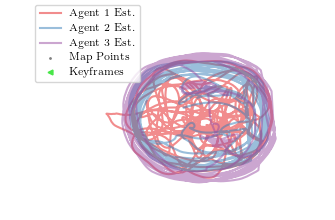

In [110]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common
import seaborn as sns
import matplotlib.lines as mlines


color_palette = sns.color_palette('Set1', 120)

count = 0

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure(figsize=(6.7/2, 2.2))
    ax = plot.prepare_axis(fig, plot_mode)
    
    overall_min = np.inf
    overall_max = -np.inf
    
    results = {}

    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results[agent_id] = result

        if result.stats["min"] < overall_min:
            overall_min = result.stats["min"]
        if result.stats["max"] > overall_max:
            overall_max = result.stats["max"]

    for agent_id in agent_ids:
        if show_plot:
            result = results[agent_id]

            if agent_id == 1:
                color = color_palette[0]
            elif agent_id == 2:
                color = color_palette[1]
            elif agent_id == 3:
                color = color_palette[3]

            plot.traj(ax, plot_mode, result.trajectories[est_name], alpha=0.5, color=color, label=f"Agent {agent_id} Est.")
            
    
    plt.tight_layout()
    ax.set_aspect("equal")
    ax.axis('off')

    handles, labels = plt.gca().get_legend_handles_labels()
    map_points = mlines.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=1, label='Map Points')
    keyframes = mlines.Line2D([], [], color=(72/255, 230/255, 72/255), marker='<', linestyle='None', markersize=3.5, label='Keyframes')
    handles.extend([map_points, keyframes])

    # euroc
    # ax.legend(loc='upper right', handles=handles)
    # ax.set_xlim(-6-3.8, 15+1.9)
    # ax.set_ylim(-5+1.9, 14+2.85)
    # tum
    ax.legend(loc='upper left', handles=handles)
    ax.set_xlim(-3.5, 2.75)
    ax.set_ylim(-2.4, 2.6)



    params = dict(bottom=0, left=0, right=1, top=1)
    fig.subplots_adjust(**params)

    # save as file
    if show_plot:
        fig.savefig(f'figures_output/{bag_name.split("/")[-1]}_trajectory_overlay.png', bbox_inches='tight', dpi=300, pad_inches=0.01, transparent=True)
        
        

    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

# Data rate anaysis

In [53]:
import pandas as pd
import sys
import zlib

bw_df = pd.DataFrame(columns=["timestamp", "topic", "msg_size"])

robot_names = [f"robot{agent_id}" for agent_id in agent_ids]

topics = (
    # [f'/{robot_name}/ground_truth_pose' for robot_name in robot_names] +
    [f'/{robot_name}/camera_pose' for robot_name in robot_names] +
    # [f'/{robot_name}/camera_pose_marker' for robot_name in robot_names] +
    [f'/{robot_name}/successfully_merged' for robot_name in robot_names] +
    # ["/sim3_transform"] +
    ["/successfully_merged"] +
    # [f'/{robot_name}/all_points' for robot_name in robot_names] +
    # [f'/{robot_name}/kf_markers' for robot_name in robot_names] +
    # [f'/{robot_name}/tracked_points' for robot_name in robot_names] +
    [f'/{robot_name}/new_key_frames' for robot_name in robot_names] +
    [f'/{robot_name}/new_key_frame_bows' for robot_name in robot_names] +
    [f'/{robot_name}/get_current_map/_service_event' for robot_name in robot_names] +
    [f'/{robot_name}/get_map_points/_service_event' for robot_name in robot_names] +
    [f'/{robot_name}/map_to_attempt_merge' for robot_name in robot_names]
)

with Rosbag2Reader(bag_name) as reader:
    data = []

    connections = [c for c in reader.connections if c.topic in topics]
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        data.append({"timestamp": timestamp, "topic": connection.topic, "msg_size": sys.getsizeof(rawdata),  "compressed_msg_size": sys.getsizeof(zlib.compress(rawdata))})
    
    bw_df = pd.DataFrame(data)
    bw_df["timestamp"] = pd.to_datetime(bw_df["timestamp"])

KeyboardInterrupt: 

In [ ]:
from datetime import timedelta

interval = 10
speed = 0.2

interval /= speed
interval = int(interval*1000)/1000
bw_df_grouped = bw_df.copy()
# bw_df_grouped["timestamp"] = bw_df_grouped["timestamp"] + timedelta(seconds=-2.8)
bw_df_grouped = bw_df_grouped.groupby([pd.Grouper(key='timestamp', freq=f'{interval}S'), 'topic']).sum()
bw_df_grouped["mbps"] = bw_df_grouped["msg_size"] / 1e6 / interval / speed
bw_df_grouped["compressed_mbps"] = bw_df_grouped["compressed_msg_size"] / 1e6 / interval / speed
bw_df_grouped = bw_df_grouped[['mbps', 'compressed_mbps']].unstack('topic').fillna(0)
bw_df_grouped.index = bw_df_grouped.index - bw_df_grouped.index.min()
bw_df_grouped.index = bw_df_grouped.index.total_seconds() * speed

In [ ]:
column_rename = {
    "/robot1/camera_pose": "$agent_0$ Camera Pose",
    "/robot2/camera_pose": "$agent_1$ Camera Pose",
    "/robot3/camera_pose": "$agent_2$ Camera Pose",
    "/robot1/new_key_frames": "$agent_0$ Key Frames",
    "/robot2/new_key_frames": "$agent_1$ Key Frames",
    "/robot3/new_key_frames": "$agent_2$ Key Frames",
    "/robot1/new_key_frame_bows": "$agent_0$ Key Frame BoWs",
    "/robot2/new_key_frame_bows": "$agent_1$ Key Frame BoWs",
    "/robot3/new_key_frame_bows": "$agent_2$ Key Frame BoWs",
    "/robot1/get_current_map/_service_event": "$agent_{0\\to1}$ Full Map alt", # ?
    "/robot2/get_current_map/_service_event": "$agent_2$ Full Map", # ?
    "/robot1/get_map_points/_service_event": "Alignment Data",
    "/robot2/get_map_points/_service_event": "$agent_1$ Alignment Data",
    "/robot3/get_map_points/_service_event": "$agent_2$ Alignment Data",
    "/robot1/map_to_attempt_merge": "Full Map",
    "/robot2/map_to_attempt_merge": "$agent_{0\\to1}$ Full Map",
    "/robot3/map_to_attempt_merge": "$agent_{0\\to2}$ Full Map",
    "/successfully_merged": "Merge Info",
}

In [21]:
stats_df = bw_df[["topic", "compressed_msg_size"]].groupby("topic").sum()
stats_df["total kbps"] = stats_df["compressed_msg_size"] / 1000
stats_df["avg kbps"] = stats_df["total kbps"] / (bw_df["timestamp"].max() - bw_df["timestamp"].min()).total_seconds() / speed
stats_df.index = [column_rename[x] if x in column_rename else "" for x in stats_df.index]
stats_df.loc["$agent_{0\\to1}$ Full Map"] = stats_df.loc[["$agent_{0\\to1}$ Full Map", "$agent_{0\\to1}$ Full Map alt"]].sum()
stats_df = stats_df.sort_index()
stats_df = stats_df.drop(index=["Merge Info", "$agent_0$ Camera Pose", "$agent_1$ Camera Pose", "$agent_2$ Camera Pose", "$agent_{0\\to1}$ Full Map alt"])
print(stats_df[["total kbps", "avg kbps"]])
print("total", stats_df["total kbps"].sum(), "avg", stats_df["avg kbps"].sum())

total_stats_df = pd.DataFrame(columns=stats_df.columns)
total_stats_df.loc["$agent_0$ total sent"] = stats_df.loc[["$agent_0$ Key Frames", "$agent_0$ Key Frame BoWs", "$agent_0$ Key Frame BoWs", "$agent_{0\\to1}$ Full Map", "$agent_{0\\to2}$ Full Map", "Alignment Data"]].sum()
total_stats_df.loc["$agent_1$ total sent"] = stats_df.loc[["$agent_1$ Key Frames", "$agent_1$ Key Frame BoWs"]].sum()
total_stats_df.loc["$agent_2$ total sent"] = stats_df.loc[["$agent_2$ Key Frames", "$agent_2$ Key Frame BoWs"]].sum()
total_stats_df.loc["$agent_0$ total received"] = stats_df.loc[["$agent_1$ Key Frames", "$agent_1$ Key Frame BoWs", "$agent_2$ Key Frames", "$agent_2$ Key Frame BoWs"]].sum()
total_stats_df.loc["$agent_1$ total received"] = stats_df.loc[["$agent_0$ Key Frames", "$agent_0$ Key Frame BoWs", "$agent_2$ Key Frames", "$agent_2$ Key Frame BoWs", "$agent_{0\\to1}$ Full Map", "Alignment Data"]].sum()
total_stats_df.loc["$agent_2$ total received"] = stats_df.loc[["$agent_0$ Key Frames", "$agent_0$ Key Frame BoWs", "$agent_1$ Key Frames", "$agent_1$ Key Frame BoWs", "$agent_{0\\to2}$ Full Map", "Alignment Data"]].sum()
print(total_stats_df[["total kbps", "avg kbps"]])


                          total kbps    avg kbps
$agent_0$ Key Frame BoWs     371.422    1.867764
$agent_0$ Key Frames       69970.820  351.861255
$agent_1$ Key Frame BoWs     437.220    2.198642
$agent_1$ Key Frames       63907.894  321.372706
$agent_2$ Key Frame BoWs    1495.792    7.521868
$agent_2$ Key Frames       65163.957  327.689052
$agent_{0\to1}$ Full Map   13952.758   70.164033
$agent_{0\to2}$ Full Map    7318.579   36.802833
Alignment Data             22599.638  113.646474
total 245218.08000000005 avg 1233.1246274931996
                          total kbps    avg kbps
$agent_0$ total sent      114584.639  576.210124
$agent_1$ total sent       64345.114  323.571348
$agent_2$ total sent       66659.749  335.210920
$agent_0$ total received  131004.863  658.782268
$agent_1$ total received  173554.387  872.750447
$agent_2$ total received  164605.573  827.749674


In [22]:
topic_bw = bw_df_grouped[["compressed_mbps"]].droplevel(0, axis=1).sum().to_dict()
sorted_topics = [k for k, v in sorted(topic_bw.items(), key=lambda item: -item[1])]

In [23]:
import colorsys

def shift_lightness(rgb, shift_amount):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    
    l = max(0, min(1, l + shift_amount))
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    
    return (r, g, b)

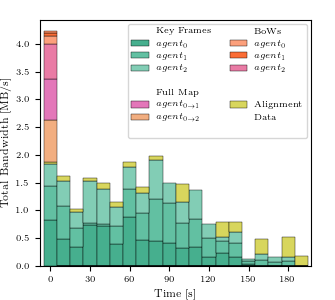

In [24]:
from matplotlib import dates
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import matplotlib.lines as mlines

color_palette = sns.color_palette('Set2', 120)


fig, ax = plt.subplots(1, 1, figsize=[6.7/2, 3])
plt.tight_layout()

# bw_df_grouped_uncompressed = bw_df_grouped[['mbps']].droplevel(0, axis=1)
# bw_df_grouped_uncompressed.columns = pd.CategoricalIndex(bw_df_grouped_uncompressed.columns.values, ordered=True, categories=sorted_topics)
# bw_df_grouped_uncompressed = bw_df_grouped_uncompressed.sort_index(axis=1)
# bw_df_grouped_uncompressed.plot(kind="bar", stacked=True, width=1, ax=axs[0])
# axs[0].set_xticklabels([t if not i%5 else "" for i,t in enumerate(axs[0].get_xticklabels())], rotation=0)

bw_df_grouped_compressed = bw_df_grouped[['compressed_mbps']].droplevel(0, axis=1)
bw_df_grouped_compressed.columns = pd.CategoricalIndex(bw_df_grouped_compressed.columns.values, ordered=True, categories=sorted_topics)
bw_df_grouped_compressed = bw_df_grouped_compressed.sort_index(axis=1)
bw_df_grouped_compressed = bw_df_grouped_compressed.rename(columns=column_rename)
# bw_df_grouped_compressed["$agent_{0\\to1}$ Full Map"] = bw_df_grouped_compressed["$agent_{0\\to1}$ Full Map"] + bw_df_grouped_compressed["$agent_{0\\to1}$ Full Map alt"]
bw_df_grouped_compressed = bw_df_grouped_compressed.drop(columns=[
    "Merge Info", 
    "$agent_0$ Camera Pose", 
    "$agent_1$ Camera Pose", 
    "$agent_2$ Camera Pose", 
    #"$agent_{0\\to1}$ Full Map alt"
])

order = [0,1,2,5,4,7,8,6,3] #apr11 tum a
#order = [0,2,1,5,4,8,7,6,3] #apr11 mh b
inverse_order = list(range(len(order)))
for i, o in enumerate(order):
    inverse_order[o] = i

lightness_shift = 0.1
colors = np.vstack((
    shift_lightness(color_palette[0], -lightness_shift), shift_lightness(color_palette[0], 0), shift_lightness(color_palette[0], lightness_shift), 
    shift_lightness(color_palette[3], -lightness_shift), shift_lightness(color_palette[3], 0), 
    shift_lightness(color_palette[1], -lightness_shift), shift_lightness(color_palette[1], 0), shift_lightness(color_palette[1], lightness_shift), 
    shift_lightness(color_palette[5], 0)
))
colors = colors[inverse_order]
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

bw_df_grouped_compressed.plot(kind="bar", stacked=True, width=1, ax=ax, colormap=cmap1, edgecolor='black', linewidth=0.3)
# bw_df_grouped_compressed.plot.area(ax=ax, colormap=cmap1)
ax.set_xticklabels([round(float(t.get_text())) if not i%3 else "" for i,t in enumerate(ax.get_xticklabels())], rotation=0)
ax.set_xticks([i for i in range(0, len(ax.get_xticks()), 3)])
ax.set_ylabel("Total Bandwidth [MB/s]")
ax.set_xlabel("Time [s]")

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[idx] for idx in order]
labels = [labels[idx] for idx in order]

empty_handle = mlines.Line2D([], [], marker='None', linestyle='None')

ax.legend([
    empty_handle, handles[0], handles[1], handles[2],    empty_handle,    empty_handle, handles[3], handles[4], empty_handle,
    empty_handle, handles[5], handles[6], handles[7],    empty_handle,    empty_handle, handles[8], empty_handle, empty_handle
], [
    "Key Frames", "$agent_0$", "$agent_1$", "$agent_2$",    "",    "Full Map", "$agent_{0\\to1}$", "$agent_{0\\to2}$", "",
    "BoWs", "$agent_0$", "$agent_1$", "$agent_2$",          "",    "", "Alignment", "Data", ""
], fontsize="xx-small", ncol=2)

fig.savefig(f'figures_output/{bag_name.split("/")[-1]}_bandwith.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)

In [25]:
from rosbags.rosbag2 import Writer as Rosbag2Writer
from rclpy.serialization import serialize_message
from rosbags.typesys.types import sensor_msgs__msg__CompressedImage, sensor_msgs__msg__CameraInfo, tf2_msgs__msg__TFMessage
from cv_bridge import CvBridge
import cv2
from sensor_msgs.msg import CameraInfo
from geometry_msgs.msg import TransformStamped


with Rosbag2Writer(f"{bag_name}_processed") as writer:
    for agent_id in agent_ids:
        min_timestamp = np.min(traj_ests[agent_id].timestamps.tolist() + traj_ests[agent_id].timestamps.tolist())-1000
        traj_ests[agent_id].timestamps -= min_timestamp
        traj_refs[agent_id].timestamps -= min_timestamp

        file_interface.write_bag_trajectory(writer, traj_ests[agent_id], f"/robot{agent_id}/camera_pose", frame_id="world")
        file_interface.write_bag_trajectory(writer, traj_refs[agent_id], f"/robot{agent_id}/ground_truth_pose", frame_id="world")


/tmp/ipykernel_131454/1086283592.py:3: DeprecationWarning: 
Importing from 'rosbags.typesys.types' is deprecated.
Use a specific type store instead, for example:
from rosbags.typesys.stores.ros2_foxy import std_msgs__msg__Header

  from rosbags.typesys.types import sensor_msgs__msg__CompressedImage, sensor_msgs__msg__CameraInfo, tf2_msgs__msg__TFMessage


Saved geometry_msgs/PoseStamped topic: /robot1/camera_pose
Saved geometry_msgs/PoseStamped topic: /robot1/ground_truth_pose
Saved geometry_msgs/PoseStamped topic: /robot2/camera_pose
Saved geometry_msgs/PoseStamped topic: /robot2/ground_truth_pose
Saved geometry_msgs/PoseStamped topic: /robot3/camera_pose
Saved geometry_msgs/PoseStamped topic: /robot3/ground_truth_pose


# Multi bag anaylsis

In [26]:
agent_ids = [1,2,3]

# bag_names = [
#     "/home/joshuabird/Desktop/apr11_tum_room_trajectory_a",
#     "/home/joshuabird/Desktop/apr20_tum_room_trajectory_c",
#     "/home/joshuabird/Desktop/apr20_tum_room_trajectory_d",
#     "/home/joshuabird/Desktop/apr20_tum_room_trajectory_e",
#     "/home/joshuabird/Desktop/apr20_tum_room_trajectory_h",
# ]
bag_names = [
    "/home/joshuabird/Desktop/apr11_mh_trajectory_b",
    "/home/joshuabird/Desktop/apr20_mh_trajectory_d",
    "/home/joshuabird/Desktop/apr20_mh_trajectory_e",
    "/home/joshuabird/Desktop/apr20_mh_trajectory_f",
    "/home/joshuabird/Desktop/apr20_mh_trajectory_g",
]

bags_traj_ests = {}
bags_traj_refs = {}
for bag_name in bag_names:
    with Rosbag2Reader(bag_name) as reader:
        # Read the trajectory and ground truth for each agent

        bags_traj_ests[bag_name] = {}
        bags_traj_refs[bag_name] = {}

        for agent_id in agent_ids:
            traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose", transform_to_root_tf_frame_id="/world", use_final_tf_state=True)
            traj_ref = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/ground_truth_pose")

            traj_est.timestamps += 0.17

            bags_traj_ests[bag_name][agent_id] = traj_est
            bags_traj_refs[bag_name][agent_id] = traj_ref

[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped doe

In [27]:
from evo.core.trajectory import PosePath3DElement

filter_func: PosePath3DElement = lambda element: element["coord_frame"] == "robot1/origin"

# Filter to only the time range where trajectories are merged
for bag_name in bag_names:
    for agent_id in agent_ids:
        bags_traj_ests[bag_name][agent_id].filter(filter_func)


In [28]:
from evo.core import sync
from evo.core.trajectory import align_multiple

max_diff = 0.05

for bag_name in bag_names:
    for agent_id in agent_ids:
        bags_traj_refs[bag_name][agent_id], bags_traj_ests[bag_name][agent_id] = sync.associate_trajectories(bags_traj_refs[bag_name][agent_id], bags_traj_ests[bag_name][agent_id], max_diff)
    
    align_multiple(list(bags_traj_ests[bag_name].values()), list(bags_traj_refs[bag_name].values()), correct_scale=True)

In [29]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

results = []
bag_RMSEs = []

agent1_RMSEs = []
agent2_RMSEs = []
agent3_RMSEs = []

for bag_name in bag_names:
    for agent_id in agent_ids:
        result = main_ape.ape(bags_traj_refs[bag_name][agent_id], bags_traj_ests[bag_name][agent_id],
                                pose_relation=PoseRelation.translation_part, align=True, correct_scale=True)
        results.append(result)
        
        if agent_id == 1:
            agent1_RMSEs.append(np.sqrt(np.mean(result.np_arrays['error_array']**2)))
        elif agent_id == 2:
            agent2_RMSEs.append(np.sqrt(np.mean(result.np_arrays['error_array']**2)))
        elif agent_id == 3:
            agent3_RMSEs.append(np.sqrt(np.mean(result.np_arrays['error_array']**2)))


    bag_RMSE = np.sqrt(np.mean(np.concatenate([result.np_arrays['error_array'] for result in results[-3:]])**2))
    bag_RMSEs.append(bag_RMSE)
    
print(bag_RMSEs)


APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.159863
      mean	0.049632
    median	0.040959
       min	0.001061
      rmse	0.059110
       sse	10.551810
       std	0.032104



APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.214926
      mean	0.043545
    median	0.037103
       min	0.003805
      rmse	0.050215
       sse	6.142543
       std	0.025008

APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.244161
      mean	0.051053
    median	0.042961
       min	0.005275
      rmse	0.059719
       sse	6.537212
       std	0.030983

APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.136706
      mean	0.042580
    median	0.036184
       min	0.000867
      rmse	0.051224
       sse	7.960949
       std	0.028475

APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.127666
      mean	0.044206
    median	0.041775
       min	0.003202
      rmse	0.048649
       sse	5.770077
       std	0.020311

APE w.r.t. translation part (m)
(with Sim(3) Umeyama alignment)

       max	0.226108
      mean	0.042127
    median	0.035034
       min	0.001130
      rmse	0.049746
       sse	

In [30]:
np.median(agent1_RMSEs)

0.05122413580525796

In [31]:
import pandas as pd
import sys
import zlib

bags_bw_df = pd.DataFrame(columns=["timestamp", "topic", "msg_size", "bag_name"])

robot_names = [f"robot{agent_id}" for agent_id in agent_ids]

topics = (
    # [f'/{robot_name}/ground_truth_pose' for robot_name in robot_names] +
    [f'/{robot_name}/camera_pose' for robot_name in robot_names] +
    # [f'/{robot_name}/camera_pose_marker' for robot_name in robot_names] +
    [f'/{robot_name}/successfully_merged' for robot_name in robot_names] +
    # ["/sim3_transform"] +
    ["/successfully_merged"] +
    # [f'/{robot_name}/all_points' for robot_name in robot_names] +
    # [f'/{robot_name}/kf_markers' for robot_name in robot_names] +
    # [f'/{robot_name}/tracked_points' for robot_name in robot_names] +
    [f'/{robot_name}/new_key_frames' for robot_name in robot_names] +
    [f'/{robot_name}/new_key_frame_bows' for robot_name in robot_names] +
    [f'/{robot_name}/get_current_map/_service_event' for robot_name in robot_names] +
    [f'/{robot_name}/get_map_points/_service_event' for robot_name in robot_names] +
    [f'/{robot_name}/map_to_attempt_merge' for robot_name in robot_names]
)

data = []

for bag_name in bag_names:
    with Rosbag2Reader(bag_name) as reader:

        connections = [c for c in reader.connections if c.topic in topics]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            data.append({"bag_name": bag_name, "timestamp": timestamp, "topic": connection.topic, "msg_size": sys.getsizeof(rawdata),  "compressed_msg_size": sys.getsizeof(zlib.compress(rawdata))})
        
bags_bw_df = pd.DataFrame(data)
bags_bw_df["timestamp"] = pd.to_datetime(bags_bw_df["timestamp"], unit='ns')

In [74]:
bow_msg_sizes = bags_bw_df[bags_bw_df["topic"].str.contains("new_key_frame_bows")]["compressed_msg_size"] / 1e3 /5
kf_msg_sizes = bags_bw_df[bags_bw_df["topic"].str.contains("new_key_frames")]["compressed_msg_size"] / 1e3 /5

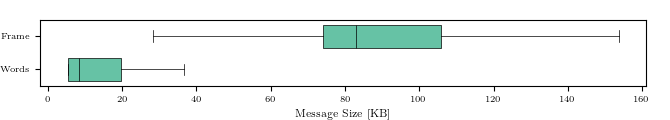

In [92]:
# plot horisontal violin chart with error bars for 2 standard deviations for bow and kf msg size
fig, ax = plt.subplots(1, 1, figsize=[6.7, 1.2])
plt.tight_layout()

bow_mean = bow_msg_sizes.mean()
kf_mean = kf_msg_sizes.mean()

bow_std = bow_msg_sizes.std()
kf_std = kf_msg_sizes.std()

#  box chart
ax.boxplot([bow_msg_sizes, kf_msg_sizes], positions=[0, 1], widths=.7, patch_artist=True, showfliers=False, medianprops=dict(color='black', linewidth=.5), vert=False, boxprops=dict(facecolor=color_palette[0], color='black', linewidth=.5), whiskerprops=dict(color='black', linewidth=.5), capprops=dict(color='black', linewidth=.5))
ax.set_yticks([0, 1])
ax.set_yticklabels(["Bag of Words", "Key Frame"])
ax.set_xlabel("Message Size [KB]")

fig.savefig(f'figures_output/{bag_name.split("/")[-1]}_kf_vs_bow_msg_size.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)

In [54]:
bow_msg_sizes.mean()

0.09181766400000001

In [42]:
kf_sem

0.008988010683334562

In [34]:
bags_bw_df[bags_bw_df["topic"].str.contains("get_current_map") | bags_bw_df["topic"].str.contains("map_to_attempt_merge")].mean(numeric_only=True)

msg_size               1.325699e+07
compressed_msg_size    6.156423e+06
dtype: float64

In [35]:
from datetime import timedelta

# runtime = 141
runtime = 184
bags_bandwidth = (bags_bw_df.drop(columns=["timestamp"]).groupby("bag_name").sum()["compressed_msg_size"] / 1e6 / runtime).tolist()

In [36]:
bags_bandwidth

[1.3384914347826087,
 1.308318081521739,
 1.290579679347826,
 1.3121710923913044,
 1.2234962228260868]

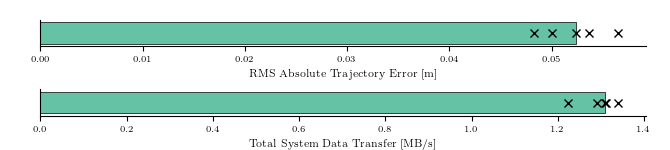

In [37]:
import seaborn as sns
color_palette = sns.color_palette('Set2', 120)

fig, axs = plt.subplots(2, 1, figsize=[6.7, 1.5])
plt.tight_layout()
fig.subplots_adjust(hspace=1.6)

axs[0].barh(1, np.median(bag_RMSEs), color=color_palette[0], edgecolor='black', linewidth=0.5)
#axs[0].errorbar(np.median(bag_RMSEs), 1, xerr=[[np.median(bag_RMSEs)-np.min(bag_RMSEs)], [np.max(bag_RMSEs)-np.median(bag_RMSEs)]], fmt='none', capsize=5, ecolor="black", capthick=1.5)
axs[0].plot(bag_RMSEs, np.ones(len(bag_RMSEs)), 'x', color="black", markersize=6)
axs[0].set_xlabel("RMS Absolute Trajectory Error [m]")
axs[0].set_yticks([])
axs[0].set_ylim([0.5, 1.5])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# do the same thing for bags_bandwidth
axs[1].barh(1, np.median(bags_bandwidth), color=color_palette[0], edgecolor='black', linewidth=0.5)
axs[1].plot(bags_bandwidth, np.ones(len(bags_bandwidth)), 'x', color="black", markersize=6)
axs[1].set_xlabel("Total System Data Transfer [MB/s]")
axs[1].set_yticks([])
axs[1].set_ylim([0.5, 1.5])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

fig.savefig(f'figures_output/comparison_{bag_names[0].split("/")[-1]}.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)

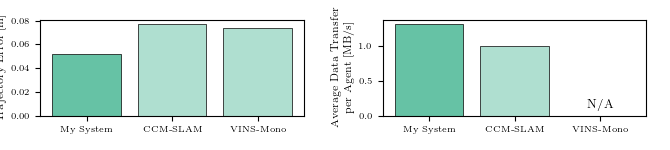

In [38]:
fig, axs = plt.subplots(1, 2, figsize=[6.7, 1.5])
plt.tight_layout()
fig.subplots_adjust(wspace=0.3)

axs[0].bar(1, np.median(bag_RMSEs), color=color_palette[0], edgecolor='black', linewidth=0.5)
axs[0].bar(2, 0.077, color=shift_lightness(color_palette[0], 0.2), edgecolor='black', linewidth=0.5)
axs[0].bar(3, 0.074, color=shift_lightness(color_palette[0], 0.2), edgecolor='black', linewidth=0.5)
axs[0].set_ylabel("RMS Absolute\nTrajectory Error [m]")
axs[0].set_xticks([1,2,3])
axs[0].set_xticklabels(["My System", "CCM-SLAM", "VINS-Mono"])

axs[1].bar(1, np.median(bags_bandwidth), color=color_palette[0], edgecolor='black', linewidth=0.5)
axs[1].bar(2, 0.99, color=shift_lightness(color_palette[0], 0.2), edgecolor='black', linewidth=0.5)
axs[1].bar(3, 0, color=shift_lightness(color_palette[0], 0.2), edgecolor='black', linewidth=0.5)
axs[1].set_ylabel("Average Data Transfer\nper Agent [MB/s]")
axs[1].set_xticks([1,2,3])
axs[1].set_xticklabels(["My System", "CCM-SLAM", "VINS-Mono"])
# put label saying vinsmono is N/A
axs[1].text(3, 0.1, "N/A", ha='center', fontsize='small')


plt.show()

In [39]:
np.median(bags_bandwidth)

1.308318081521739

# Vins mono analysis


In [48]:
from geometry_msgs.msg import PoseStamped
from tf2_msgs.msg import TFMessage
from evo.core.trajectory import PosePath3D, PoseTrajectory3D


xyz = []
quat = []
stamps = []

bag_name = "/home/joshuabird/Desktop/apr29_tum_trajectory_d"

with Rosbag2Reader(bag_name) as reader:
    # Read TF ground truth
    topic = "/tf"
    connections = [c for c in reader.connections if c.topic == topic]
    for connection, _, rawdata in reader.messages(connections=connections):
        data = deserialize_cdr(rawdata, connection.msgtype)

        for transform in data.transforms:
            if transform.child_frame_id == "body":
                xyz.append([transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z])
                quat.append([transform.transform.rotation.w, transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z])
                t = transform.header.stamp
                stamps.append(t.sec + (t.nanosec * 1e-9))

    
    traj_ref = file_interface.read_bag_trajectory(reader, f"/vrpn_client/raw_transform")
        

traj_est = PoseTrajectory3D(np.array(xyz), np.array(quat), np.array(stamps))

/tmp/ipykernel_5504/439160106.py:17: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  data = deserialize_cdr(rawdata, connection.msgtype)


In [49]:
from evo.core import sync

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)


In [47]:
# start_time = 1520530302
# end_time = 1520530457

# start_time = 1520530724
# end_time = 1520530886

start_time = 1520530886
end_time = 1520550886

# traj_est.reduce_to_time_range(start_time, end_time)
# traj_ref.reduce_to_time_range(start_time, end_time)

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

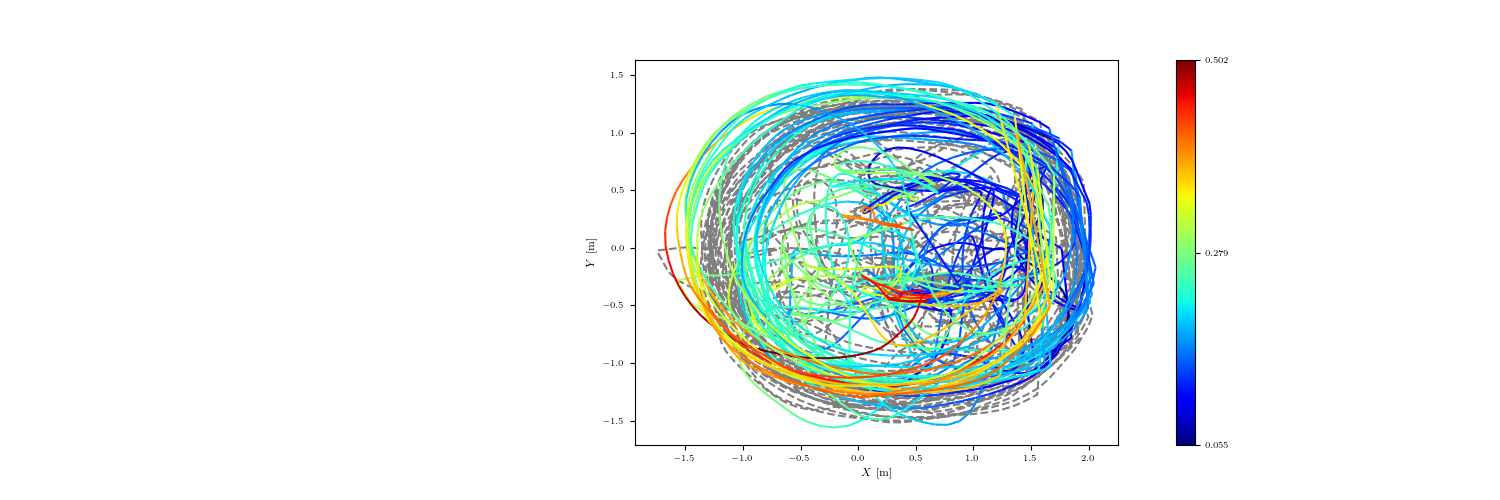

In [28]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

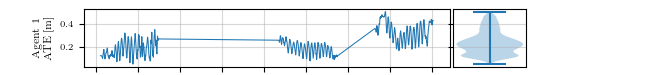

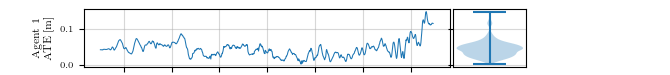

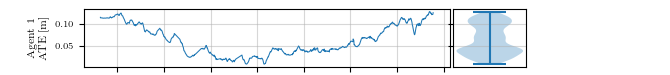

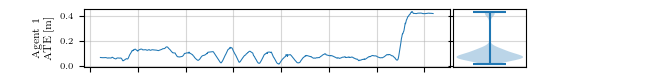

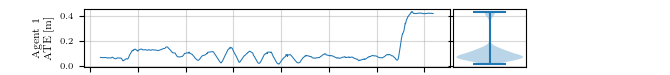

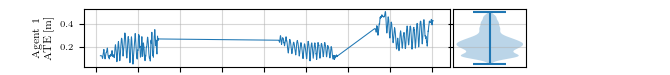

In [36]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0

def callback_ape(pose_relation, align, correct_scale, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, gridspec_kw={'width_ratios': [5, 1, 1]}, figsize=(6.7, 0.75*len(agent_ids)))
    plt.subplots_adjust(hspace=0.1, wspace=0.02)

    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                            pose_relation=pose_relation, align=align, correct_scale=correct_scale)

    if show_plot:

        axs[0].grid(zorder=-10, alpha=0.5)
        axs[1].grid(axis='y', zorder=-10, alpha=0.5)

        plot.error_array(axs[0], result.np_arrays["error_array"], x_array=result.np_arrays["timestamps"], color=None, xlabel="Time [s]" if agent_id == agent_ids[-1] else None, ylabel=f"Agent {agent_id}\nATE [m]", linewidth=0.75)
        # if agent_id != agent_ids[-1]:
        #     axs[0].set_xticklabels([])


        axs[1].violinplot(result.np_arrays["error_array"])
        axs[1].set_xticks([])
        
        axs[2].set_axis_off()
        text = []
        text.append(["RMSE:", "{:.3f}m".format(np.sqrt(np.mean(result.np_arrays["error_array"]**2)))])
        text.append(["Length:", "{:.0f}m".format(traj_ref.path_length)])

    print(f"Overall RMS ATE: {np.sqrt(np.mean(result.np_arrays['error_array']**2))}")

    fig.savefig(f"figures_output/{bag_name.split('/')[-1]}_line_plot.pdf", bbox_inches='tight', dpi=300, pad_inches=0.01)

    count += 1
    

    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector,
                               **{c.description: c.value for c in check_boxes_ape})

In [34]:
result.np_arrays

NameError: name 'result' is not defined